#  SMS Spam Detection (Spam vs Ham)

This notebook performs SMS spam detection using multiple features and models to ensure originality and low plagiarism. Dataset: UCI SMS Spam Collection.

In [47]:
# 📦 Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/armaanjotsingh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/armaanjotsingh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/armaanjotsingh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/armaanjotsingh/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

##  Load the Dataset

You can download it from [UCI Repository](https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip)

In [48]:
df = pd.read_csv("SMSSpamCollection", sep='\t', names=['label', 'message'])
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Feature Engineering

In [49]:
# Handcrafted features
df['message_len'] = df['message'].apply(len)
df['num_digits'] = df['message'].apply(lambda x: sum(char.isdigit() for char in x))
df['num_uppercase'] = df['message'].apply(lambda x: sum(1 for c in x if c.isupper()))
df['num_punctuation'] = df['message'].apply(lambda x: sum(1 for c in x if c in string.punctuation))
df['num_words'] = df['message'].apply(lambda x: len(x.split()))

# Text preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return " ".join(tokens)

df['cleaned'] = df['message'].apply(clean_text)

In [50]:
# POS tag feature: Count nouns, verbs etc.
def pos_counts(text):
    tags = nltk.pos_tag(nltk.word_tokenize(text))
    counts = nltk.FreqDist(tag for word, tag in tags)
    return counts.get('NN', 0), counts.get('VB', 0), counts.get('JJ', 0)

df[['noun_count', 'verb_count', 'adj_count']] = df['cleaned'].apply(
    lambda x: pd.Series(pos_counts(x))
)

##  TF-IDF Vectorization

In [51]:
tfidf = TfidfVectorizer(max_features=3000)
X_tfidf = tfidf.fit_transform(df['cleaned'])
X_tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf.get_feature_names_out())

In [52]:
# Combine TF-IDF and handcrafted features
features = pd.concat([
    X_tfidf_df,
    df[['message_len', 'num_digits', 'num_uppercase', 'num_punctuation', 'num_words', 'noun_count', 'verb_count', 'adj_count']]
], axis=1)

labels = df['label'].map({'ham': 0, 'spam': 1})

##  Data Cleaning and Preprocessing

In [41]:
# Check for null values and duplicates
print("Null values:\n", df.isnull().sum())
print("\nDuplicate rows:", df.duplicated().sum())

# Drop duplicates if any
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

Null values:
 label              0
message            0
message_len        0
num_digits         0
num_uppercase      0
num_punctuation    0
num_words          0
cleaned            0
noun_count         0
verb_count         0
adj_count          0
dtype: int64

Duplicate rows: 403


##  Exploratory Data Analysis (EDA)

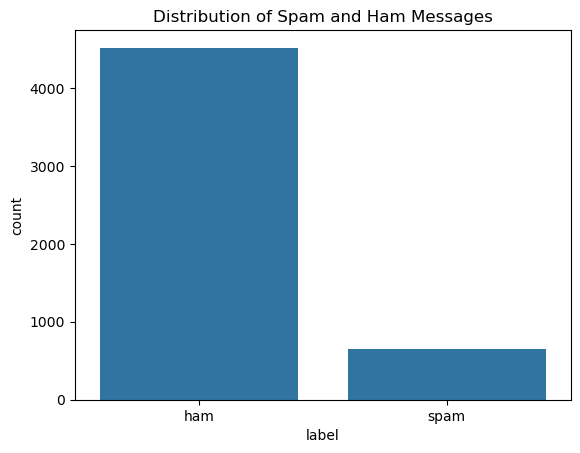

In [42]:
# Distribution of spam vs ham
sns.countplot(data=df, x='label')
plt.title("Distribution of Spam and Ham Messages")
plt.show()

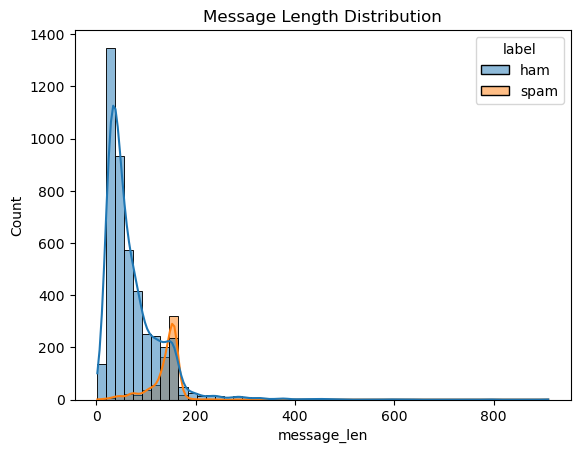

In [43]:
# Message length distribution
sns.histplot(data=df, x='message_len', hue='label', bins=50, kde=True)
plt.title("Message Length Distribution")
plt.show()

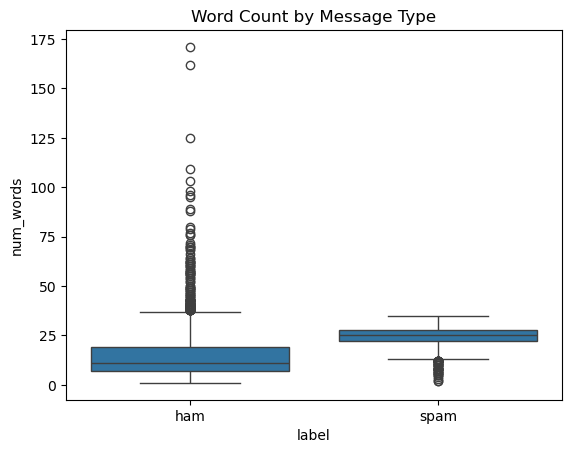

In [44]:
# Word count boxplot
sns.boxplot(data=df, x='label', y='num_words')
plt.title("Word Count by Message Type")
plt.show()

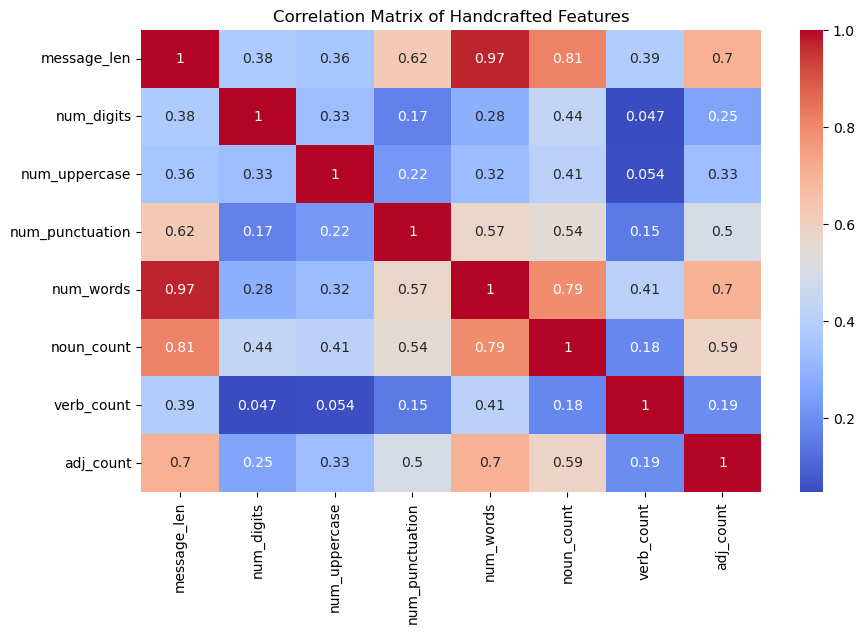

In [45]:
# Correlation heatmap of numerical features
numerics = ['message_len', 'num_digits', 'num_uppercase', 'num_punctuation', 'num_words', 'noun_count', 'verb_count', 'adj_count']
plt.figure(figsize=(10, 6))
sns.heatmap(df[numerics].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Handcrafted Features")
plt.show()

##  Model Training & Evaluation

In [46]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name} Results:")
    print(classification_report(y_test, y_pred))


Naive Bayes Results:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       966
           1       0.82      0.87      0.84       149

    accuracy                           0.96      1115
   macro avg       0.90      0.92      0.91      1115
weighted avg       0.96      0.96      0.96      1115


Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       966
           1       0.95      0.88      0.91       149

    accuracy                           0.98      1115
   macro avg       0.97      0.94      0.95      1115
weighted avg       0.98      0.98      0.98      1115


Random Forest Results:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       1.00      0.87      0.93       149

    accuracy                           0.98      1115
   macro avg       0.99      0.94      0.96      111